### Plotting embedding.

Here we try to produce an embedding in 2D that works well for plotting all clusterings.

In [1]:
import matplotlib.pyplot as plt
import pickle as pk
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import colorcet as cc
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from hdbscan.validity import validity_index

from itertools import combinations
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from utilities import run_configs, load_symptom_data, modularity, clustering_similarity

%matplotlib inline

/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rustybilges/Documents/Work/PLR

In [2]:
SEED = 42

In [3]:
# with open('./fern_ensemble_outputs_spectral/run_1_kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)

In [4]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [5]:
# final_clusters = ensemble_outputs[0]['final_clusters'][6]

In [6]:
# # chris_clusters = pd.DataFrame(index=symptom_data.index)
# chris_clusters['cluster'] = final_clusters

In [7]:
# chris_clusters = pd.read_csv('../clusterings/chris/parametric_umap_n_clusters_7.csv', index_col=0)
chris_clusters = pd.read_csv('../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_8.csv', index_col=0)

In [8]:
tessa_clusters = pd.read_csv('../clusterings/tessa/cluster_13_111023.csv', index_col=0)


In [9]:
# leo_clusters = pd.read_csv('../clusterings/leo/d2_pca_additive_hdbscan_sil_17_6031_with_ids.csv', index_col=0)
leo_clusters = pd.read_csv('../clusterings/leo/final_aencoder_hdbscan_6.csv', index_col=0)
# leo_clusters_2 = pd.read_csv('../clusterings/leo/d2_tsne_agg_opt_5_6031_with_ids.csv', index_col=0)

In [10]:
np.unique(leo_clusters.cluster, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 array([ 105, 2126, 1114,   20,  318,  495,  123,  849,   34,  847]))

In [11]:
not_noise = leo_clusters[leo_clusters.cluster != -1].index
# not_noise = leo_clusters.index

In [12]:
adjusted_mutual_info_score(
    chris_clusters.cluster,
    leo_clusters.cluster
)

0.13433315556537673

In [13]:
adjusted_mutual_info_score(
    tessa_clusters.cluster,
    leo_clusters.cluster
)

0.18572710142154927

In [14]:
adjusted_mutual_info_score(
    chris_clusters.loc[not_noise].cluster,
    leo_clusters.loc[not_noise].cluster
)

0.13615141765049293

In [15]:
adjusted_mutual_info_score(
    tessa_clusters.loc[not_noise].cluster,
    leo_clusters.loc[not_noise].cluster
)

0.1879068146530042

In [16]:
adjusted_mutual_info_score(
    chris_clusters.cluster,
    tessa_clusters.cluster
)

0.3953660351038437

In [17]:
umap_param_space = {
    'n_components': [2], 
    'n_neighbors': list(range(2, 100)),
    'min_dist': np.arange(0, 1, 0.01),
     'metric': [
        'euclidean', 
        'manhattan',
        'hamming',
        'jaccard',
        'dice',
        'russellrao',
        'kulsinski',
        'rogerstanimoto',
        'sokalmichener',
        'sokalsneath',
        'yule'
    ]
}

In [18]:
tsne_param_space = {
    'n_components': [2], 
    'perplexity': list(range(5, 100)),
    'learning_rate': list(range(10, 1000)),
    'init': ['random', 'pca'],
    'n_jobs': [-1],
    'metric': [
        'euclidean', 
        'manhattan',
        'hamming',
        'jaccard',
        'dice',
        'russellrao',
        'kulsinski',
        'rogerstanimoto',
        'sokalmichener',
        'sokalsneath',
        'yule'
    ]
}

In [19]:
params_both = {}
results_both = {}

for i in range(350):
    print(i)
    params_both[i] = {
        key: np.random.choice(tsne_param_space[key])
        for key in tsne_param_space.keys()
    }
    
    for key in tsne_param_space.keys():
        if isinstance(params_both[i][key], np.str_):
            params_both[i][key] = str(params_both[i][key])
    
    
    reducer = TSNE(**params_both[i], random_state=SEED)
    tsne_embedding = reducer.fit_transform(symptom_data)
    
    st = silhouette_score(tsne_embedding, tessa_clusters.cluster)
    sc = silhouette_score(tsne_embedding, chris_clusters.cluster)
    sl = silhouette_score(tsne_embedding, leo_clusters.cluster)
    slnn = silhouette_score(
        tsne_embedding[leo_clusters.cluster!=-1, :], 
        leo_clusters.loc[not_noise].cluster
    )
    
    tsne_embedding = tsne_embedding.astype(np.double)
    vt = validity_index(tsne_embedding, tessa_clusters.cluster)
    vc = validity_index(tsne_embedding, chris_clusters.cluster)
    vl = validity_index(tsne_embedding, leo_clusters.cluster)
    vlnn = validity_index(
        tsne_embedding[leo_clusters.cluster!=-1, :], 
        leo_clusters.loc[not_noise].cluster
    )

    results_both[i] = {
        'silhouette_tessa': st,
        'silhouette_chris': sc,
        'silhouette_leo': sl,
        'silhouette_leo_notnoise': slnn,
        'silhouette_mean': (st + sc + sl) / 3,
        
        'dbcv_tessa': vt,
        'dbcv_chris': vc,
        'dbcv_leo': vl,
        'dbcv_leo_notnoise': vlnn,
        'dbcv_mean': (vt + vc + vl) / 3,
        'embedding': tsne_embedding
    }
    
    if i % 20 == 0:
        with open('figs/temp_tsne_results.pk', 'wb') as outfile:
            pk.dump(results_both, outfile)
    
        with open('figs/temp_tsne_params.pk', 'wb') as outfile:
            pk.dump(params_both, outfile)

0


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


1
2


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


3


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


4


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


5


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


6


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


7
8
9


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


10


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


11


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


12
13


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


14
15


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


16
17
18


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


19


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


20
21


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


22
23


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


24
25


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


26
27
28


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


29


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


30


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


31


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


32
33


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


34


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


35


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


36


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


37
38
39


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


40


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


41


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


42
43


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


44


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


45


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


46


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


47


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


48


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


49


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


50
51
52


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


53


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


54


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


55


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


56
57
58
59


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


60


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


61


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


62


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


63


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


64


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


65


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


66


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


67


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


68


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


69
70


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


71


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


72


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


73
74


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


75
76


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


77


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


78
79


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


80


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


81


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


82
83
84


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


85


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


86


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


87
88


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


89
90
91


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


92
93
94


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


95


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


96
97


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


98


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


99


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


100


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


101


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


102


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


103


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


104
105


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


106


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


107


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


108


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


109
110


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


111
112


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


113
114


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


115
116


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


117


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


118
119
120


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


121
122


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


123


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


124
125


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


126


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


127
128


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


129


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


130


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


131


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


132


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


133
134


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


135
136
137


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


138


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


139


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


140


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


141


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


142
143
144


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


145


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


146


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


147


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


148
149
150


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


151


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


152


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


153


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


154


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


155


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


156


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


157


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


158
159
160


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


161


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


162
163
164


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


165


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


166


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


167


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


168


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


169


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


170


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


171


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


172
173


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


174


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


175


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


176


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


177


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


178


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


179


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


180
181


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


182


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


183


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


184


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


185


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


186


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


187


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


188
189


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


190


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


191


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


192


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


193


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


194


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


195


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


196
197


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


198
199
200


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


201


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


202


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


203
204
205


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


206


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


207


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


208
209
210


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


211


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


212


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


213
214


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


215


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


216


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


217


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


218


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


219
220
221
222


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


223


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


224


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


225


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


226


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


227


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


228


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


229
230
231


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


232


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


233


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


234


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


235
236


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


237
238


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


239
240


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


241


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


242
243


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


244


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


245


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


246


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


247


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


248


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


249


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


250
251
252


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


253
254


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


255


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


256


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


257
258
259


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


260


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


261
262
263


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


264
265
266


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


267


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


268


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


269


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


270


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


271


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


272


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


273
274


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


275
276


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


277
278


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


279


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


280


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


281


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


282


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


283


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


284
285


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


286


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


287


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


288


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


289


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


290


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


291
292
293


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


294


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


295


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


296
297


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


298


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


299


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


300


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


301


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


302


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


303


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


304


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


305


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


306


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


307
308


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


309


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


310


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


311


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


312
313
314


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


315


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


316
317


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


318


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


319


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


320


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


321


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


322


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


323
324
325


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


326


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


327


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


328


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


329
330


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


331


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


332


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


333


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


334


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


335


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


336


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


337


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)


338


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


339


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


340
341


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


342


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)


343


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


344


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


345


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


346


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)


347
348


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConversionWarning)


349


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


In [20]:
with open('figs/temp_tsne_results.pk', 'wb') as outfile:
            pk.dump(results_both, outfile)
    
with open('figs/temp_tsne_params.pk', 'wb') as outfile:
    pk.dump(params_both, outfile)

In [38]:
with open('figs/temp_tsne_results.pk', 'rb') as outfile:
            results_both = pk.load(outfile)
    
with open('figs/temp_tsne_params.pk', 'rb') as outfile:
    params_both = pk.load(outfile)

In [21]:
params_both = {}
results_both = {}

for i in range(350):
    print(i)
    params_both[i] = {
        key: np.random.choice(umap_param_space[key])
        for key in umap_param_space.keys()
    }
    
    reducer = umap.UMAP(**params_both[i], random_state=SEED)
    umap_embedding = reducer.fit_transform(symptom_data)
    
    st = silhouette_score(umap_embedding, tessa_clusters.cluster)
    sc = silhouette_score(umap_embedding, chris_clusters.cluster)
    sl = silhouette_score(umap_embedding, leo_clusters.cluster)
    slnn = silhouette_score(
        umap_embedding[leo_clusters.cluster!=-1, :], 
        leo_clusters.loc[not_noise].cluster
    )
    
    umap_embedding = umap_embedding.astype(np.double)
    vt = validity_index(umap_embedding, tessa_clusters.cluster)
    vc = validity_index(umap_embedding, chris_clusters.cluster)
    vl = validity_index(umap_embedding, leo_clusters.cluster)
    vlnn = validity_index(
        umap_embedding[leo_clusters.cluster!=-1, :], 
        leo_clusters.loc[not_noise].cluster
    )

    results_both[i] = {
        'silhouette_tessa': st,
        'silhouette_chris': sc,
        'silhouette_leo': sl,
        'silhouette_leo_notnoise': slnn,
        'silhouette_mean': (st + sc + sl) / 3,
        
        'dbcv_tessa': vt,
        'dbcv_chris': vc,
        'dbcv_leo': vl,
        'dbcv_leo_notnoise': vlnn,
        'dbcv_mean': (vt + vc + vl) / 3,
        'embedding': umap_embedding
    }
#     print(results_both[i])
    if i % 50 == 0:
        with open('figs/temp_umap_results.pk', 'wb') as outfile:
            pk.dump(results_both, outfile)
    
        with open('figs/temp_umap_params.pk', 'wb') as outfile:
            pk.dump(params_both, outfile)

0
1


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


2


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


3


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


4
5
6


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


7


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


8


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


9


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


10


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


11
12


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


13
14


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


15


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


16


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


17
18


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


19
20


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


21


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


22
23


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


24


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


25


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


26


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


27


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


28
29


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


30


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


31


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


32


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


33
34


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


35


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


36


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


37


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


38


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


39


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


40


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


41


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


42
43


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


44


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


45
46


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


47


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


48


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


49


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


50
51


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


52


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


53


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


54


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


55
56


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


57
58


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


59


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


60


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


61


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


62


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


63


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


64


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


65


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


66
67


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


68


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


69
70


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


71


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


72


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


73


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


74


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


75


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


76
77


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


78


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


79


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


80


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


81


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


82


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


83


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


84


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


85


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


86


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


87


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


88
89


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


90


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


91


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


92


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


93


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


94
95


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


96


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


97
98


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


99


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


100


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


101


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


102


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


103
104


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


105
106


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


107


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


108


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


109


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


110


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


111


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


112


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


113


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


114
115


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


116
117


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


118


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


119
120


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


121


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


122


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


123
124


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


125


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


126


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


127
128


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


129


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


130


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


131


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


132
133
134


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


135


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


136
137
138


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


139


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


140


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


141


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


142


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


143


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


144
145


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


146


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


147


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


148


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


149


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


150


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


151
152


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


153


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


154


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


155


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


156


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


157


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


158


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


159


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


160


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


161


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


162


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


163


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


164


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


165


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


166
167


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


168


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


169


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


170


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


171


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


172
173


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


174


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


175


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


176
177


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


178


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


179


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


180


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


181


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


182
183


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


184


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


185


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


186


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


187


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


188


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


189
190


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


191


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


192


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


193


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


194


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


195


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


196
197


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


198


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


199
200


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


201


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


202


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


203


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


204


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


205


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


206
207


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


208


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


209


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


210
211


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


212


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


213


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


214


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


215


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


216


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


217


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


218
219


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


220
221


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


222
223


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


224
225


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


226


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


227


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


228


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


229


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


230
231


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


232


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


233


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


234


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


235


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


236


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


237
238


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


239


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


240


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


241


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


242


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


243


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


244


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


245


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


246


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


247
248
249


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


250


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


251


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


252
253


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


254


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


255


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


256


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


257
258


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


259


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


260


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


261


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


262


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


263


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


264


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


265


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


266


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


267


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


268


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


269


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


270


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


271


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


272


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


273


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


274


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


275


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


276


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


277


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


278


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


279


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


280


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


281


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


282


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


283


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


284


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


285


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


286


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


287


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


288
289


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


290


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


291


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


292
293


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


294


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


295


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


296


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


297
298


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


299


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


300


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


301


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


302


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


303


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


304


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


305
306


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


307


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


308
309


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


310
311


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


312


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


313


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


314


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


315


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


316


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


317


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


318


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


319


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


320
321


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


322


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


323


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


324
325


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


326


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


327


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


328


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


329


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


330


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


331


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(


332


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


333


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


334


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


335


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


336
337


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


338


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


339


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


340


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


341


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


342


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


343
344


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


345


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(


346


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(


347


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


348


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


349


/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


In [22]:
with open('figs/temp_umap_results.pk', 'wb') as outfile:
            pk.dump(results_both, outfile)
    
with open('figs/temp_umap_params.pk', 'wb') as outfile:
    pk.dump(params_both, outfile)

In [39]:
results_both_df = pd.DataFrame({
    'silhouette_mean': [val['silhouette_mean'] for val in results_both.values()],
    'silhouette_chris': [val['silhouette_chris'] for val in results_both.values()],
    'silhouette_tessa': [val['silhouette_tessa'] for val in results_both.values()],
    'silhouette_leo': [val['silhouette_leo'] for val in results_both.values()],
    'silhouette_leo_notnoise': [val['silhouette_leo_notnoise'] for val in results_both.values()],
    'dbcv_mean': [val['dbcv_mean'] for val in results_both.values()],
    'dbcv_chris': [val['dbcv_chris'] for val in results_both.values()],
    'dbcv_tessa': [val['dbcv_tessa'] for val in results_both.values()],
    'dbcv_leo': [val['dbcv_leo'] for val in results_both.values()],
    'dbcv_leo_notnoise': [val['dbcv_leo_notnoise'] for val in results_both.values()],
})


In [40]:
alpha = 0.2
results_both_df['silhouette_chris_scaled'] = [(val['silhouette_chris'] * alpha) for val in results_both.values()]
results_both_df['silhouette_tessa_scaled'] = [(val['silhouette_tessa'] * (1 - alpha)) for val in results_both.values()]
results_both_df['silhouette_leo_scaled'] = [(val['silhouette_leo'] * (1 - alpha)) for val in results_both.values()]


In [41]:
results_both_df['dbcv_chris_scaled'] = [(val['dbcv_chris'] * alpha) for val in results_both.values()]
results_both_df['dbcv_tessa_scaled'] = [(val['dbcv_tessa'] * (1 - alpha)) for val in results_both.values()]
results_both_df['dbcv_leo_scaled'] = [(val['dbcv_leo'] * (1 - alpha)) for val in results_both.values()]


In [42]:
# results_both_df['objective'] = (results_both_df['silhouette_chris_scaled'] + results_both_df['silhouette_tessa_scaled'] + results_both_df['silhouette_leo_scaled']) / 3
# results_both_df['objective'] = (results_both_df['dbcv_chris_scaled'] + results_both_df['dbcv_tessa_scaled'] + results_both_df['dbcv_leo_scaled']) / 3
results_both_df['objective'] = (results_both_df['silhouette_chris'] + results_both_df['silhouette_tessa']) / 2

# results_both_df['objective'] = (results_both_df['silhouette_chris_scaled'] + results_both_df['silhouette_tessa_scaled']) / 2

In [54]:
# results_both_df.sort_values('silhouette_chris', ascending=False, inplace=True)
# results_both_df.sort_values('objective', ascending=False, inplace=True)
# results_both_df.sort_values('silhouette_tessa', ascending=False, inplace=True)
# results_both_df.sort_values('dbcv_chris', ascending=False, inplace=True)
# results_both_df.sort_values('dbcv_mean', ascending=False, inplace=True)
results_both_df.sort_values('silhouette_mean', ascending=False, inplace=True)
# results_both_df.sort_values('silhouette_leo_notnoise', ascending=False, inplace=True)
# results_both_df.sort_values('silhouette_leo', ascending=False, inplace=True)
# results_both_df.sort_values('dbcv_leo_notnoise', ascending=False, inplace=True)

In [55]:
results_both_df

,silhouette_mean,silhouette_chris,silhouette_tessa,silhouette_leo,silhouette_leo_notnoise,dbcv_mean,dbcv_chris,dbcv_tessa,dbcv_leo,dbcv_leo_notnoise,silhouette_chris_scaled,silhouette_tessa_scaled,silhouette_leo_scaled,dbcv_chris_scaled,dbcv_tessa_scaled,dbcv_leo_scaled,objective
331,0.009160,0.241214,-0.051155,-0.162581,-0.156465,-0.843468,-0.790003,-0.843982,-0.896418,-0.912302,0.048243,-0.040924,-0.130064,-0.158001,-0.675185,-0.717135,0.095030
92,0.007998,0.241899,-0.054091,-0.163814,-0.157759,-0.801533,-0.732915,-0.818282,-0.853400,-0.868521,0.048380,-0.043273,-0.131051,-0.146583,-0.654626,-0.682720,0.093904
158,0.007127,0.241263,-0.052580,-0.167304,-0.161112,-0.831912,-0.781011,-0.840026,-0.874698,-0.890196,0.048253,-0.042064,-0.133843,-0.156202,-0.672021,-0.699758,0.094342
199,0.007010,0.238949,-0.051184,-0.166734,-0.160591,-0.808834,-0.736728,-0.806089,-0.883686,-0.899343,0.047790,-0.040947,-0.133387,-0.147346,-0.644871,-0.706949,0.093882
239,0.005207,0.235722,-0.056746,-0.163357,-0.157319,-0.834108,-0.778949,-0.833318,-0.890057,-0.905827,0.047144,-0.045397,-0.130685,-0.155790,-0.666655,-0.712045,0.089488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.268141,-0.318061,-0.307030,-0.179332,-0.173841,-0.928001,-0.933978,-0.919334,-0.930692,-0.947182,-0.063612,-0.245624,-0.143465,-0.186796,-0.735467,-0.744553,-0.312546
155,-0.270144,-0.319686,-0.289089,-0.201656,-0.195714,-0.924798,-0.921846,-0.920902,-0.931644,-0.948152,-0.063937,-0.231271,-0.161325,-0.184369,-0.736722,-0.745316,-0.304387
192,-0.286955,-0.313130,-0.315523,-0.232210,-0.226318,-0.934105,-0.950848,-0.924388,-0.927079,-0.943505,-0.062626,-0.252419,-0.185768,-0.190170,-0.739510,-0.741663,-0.314327
334,-0.313239,-0.347993,-0.339388,-0.252337,-0.245689,-0.941449,-0.936982,-0.920897,-0.966469,-0.983593,-0.069599,-0.271510,-0.201870,-0.187396,-0.736718,-0.773175,-0.343691


/tmp/ipykernel_25295/788363148.py:23: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_25295/788363148.py:23: UserWarning: The palette list has more values (15) than needed (8), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_25295/788363148.py:23: UserWarning: The palette list has more values (15) than needed (13), which may not be intended.
  sns.scatterplot(


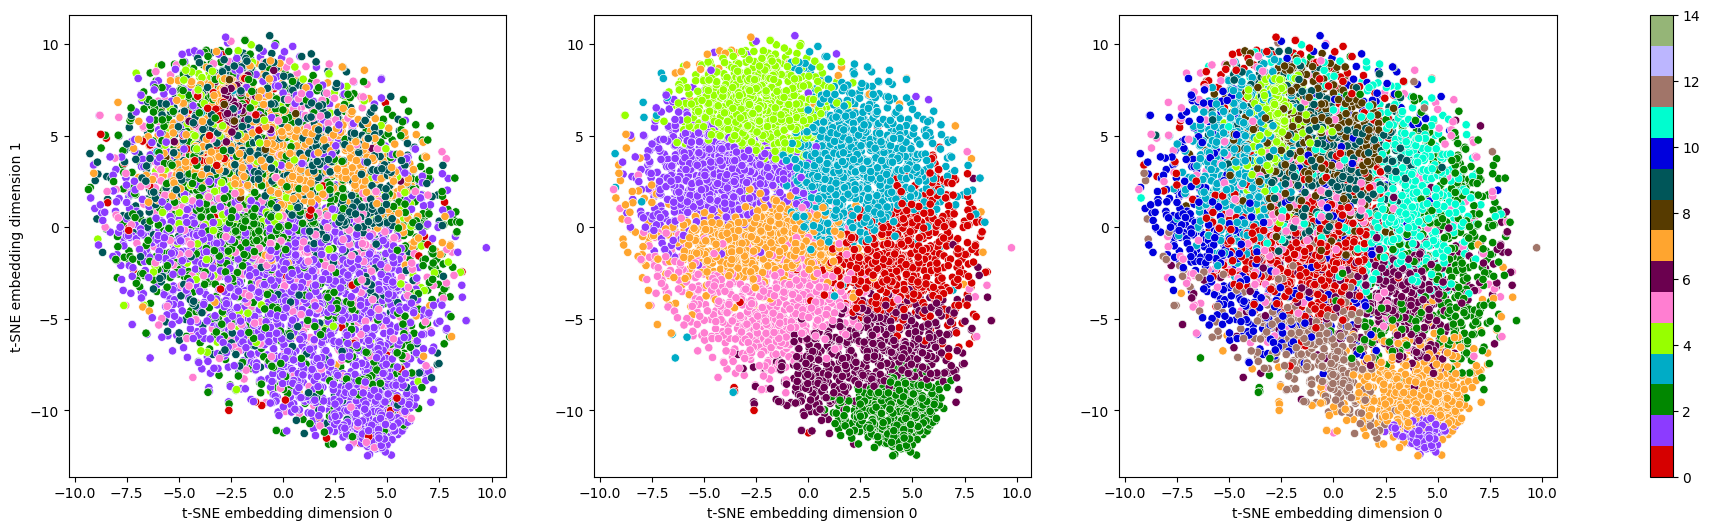

In [61]:
max_cluster_count = 14
embedding_algo = 't-SNE'

fig, ax = plt.subplots(1, 3, figsize=(24, 6))

norm = plt.Normalize(0, max_cluster_count, )
palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count+1)
cmap = ListedColormap(palette.as_hex())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cluster_lists = [
    leo_clusters.cluster,
    chris_clusters.cluster,
    tessa_clusters.cluster,
]
labels = ['A', 'B', 'C']
embedding_id = results_both_df.index[0]
em = results_both[embedding_id ]['embedding']

for i in range(3):
    
    sns.scatterplot(
        x=em[:, 0],
        y=em[:, 1],
        palette = palette,
        hue=cluster_lists[i],
        data=em,
        legend=None,
        ax=ax[i]
    )
    ax[i].set_xlabel('%s embedding dimension 0' % embedding_algo)
#     ax[i].text(
#         x=-11,
#         y=7.5,
#         s=labels[i],
#         fontsize='x-large',
#         fontweight='bold'
#     )    
#     plt.title(id)
#     ax[i].set_aspect('equal')

ax[0].set_ylabel('%s embedding dimension 1' % embedding_algo)
fig.colorbar(sm, ax=ax.flatten(), orientation="vertical");
# plt.tight_layout()
    

#### We now combine the scatter plot and the grouping heatmaps into a single figure:

In [62]:
groups_df = pd.read_csv('../clusterings/tessa/symptom_groups.csv')

In [63]:
sympdf = symptom_data

In [64]:
avg_scores_by_grouping = {}
def make_avg_scores_by_grouping(sympdf = sympdf, clustercol = 'cluster', groups_df=groups_df):
    for grouping in groups_df.group.unique():
        # calculat the average score for each symptom in the group for each cluster in 'cluster'
        keepcols = groups_df.loc[groups_df.group == grouping, 'symptom'].tolist()
        #print(keepcols)
        keepcols.append(clustercol)
        a = sympdf.loc[:, keepcols]
        avg = a.groupby(clustercol).mean()
        avg_scores_by_grouping[grouping] = avg.mean(axis=1)
        #avg = sympdf.loc[:, sympdf.columns.str.startswith(grouping)].groupby(clus).mean()
    return(pd.DataFrame(avg_scores_by_grouping))

In [65]:
sympdf['LCA'] = tessa_clusters.cluster
sympdf['Leo'] = leo_clusters.cluster
sympdf['Chris'] = chris_clusters.cluster

In [66]:
tessadf = make_avg_scores_by_grouping(clustercol = "LCA")

In [67]:
chrisdf = make_avg_scores_by_grouping(clustercol="Chris")

In [68]:
leodf = make_avg_scores_by_grouping(clustercol="Leo")

/tmp/ipykernel_25295/479009222.py:35: UserWarning: The palette list has more values (14) than needed (10), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_25295/479009222.py:35: UserWarning: The palette list has more values (14) than needed (9), which may not be intended.
  sns.scatterplot(


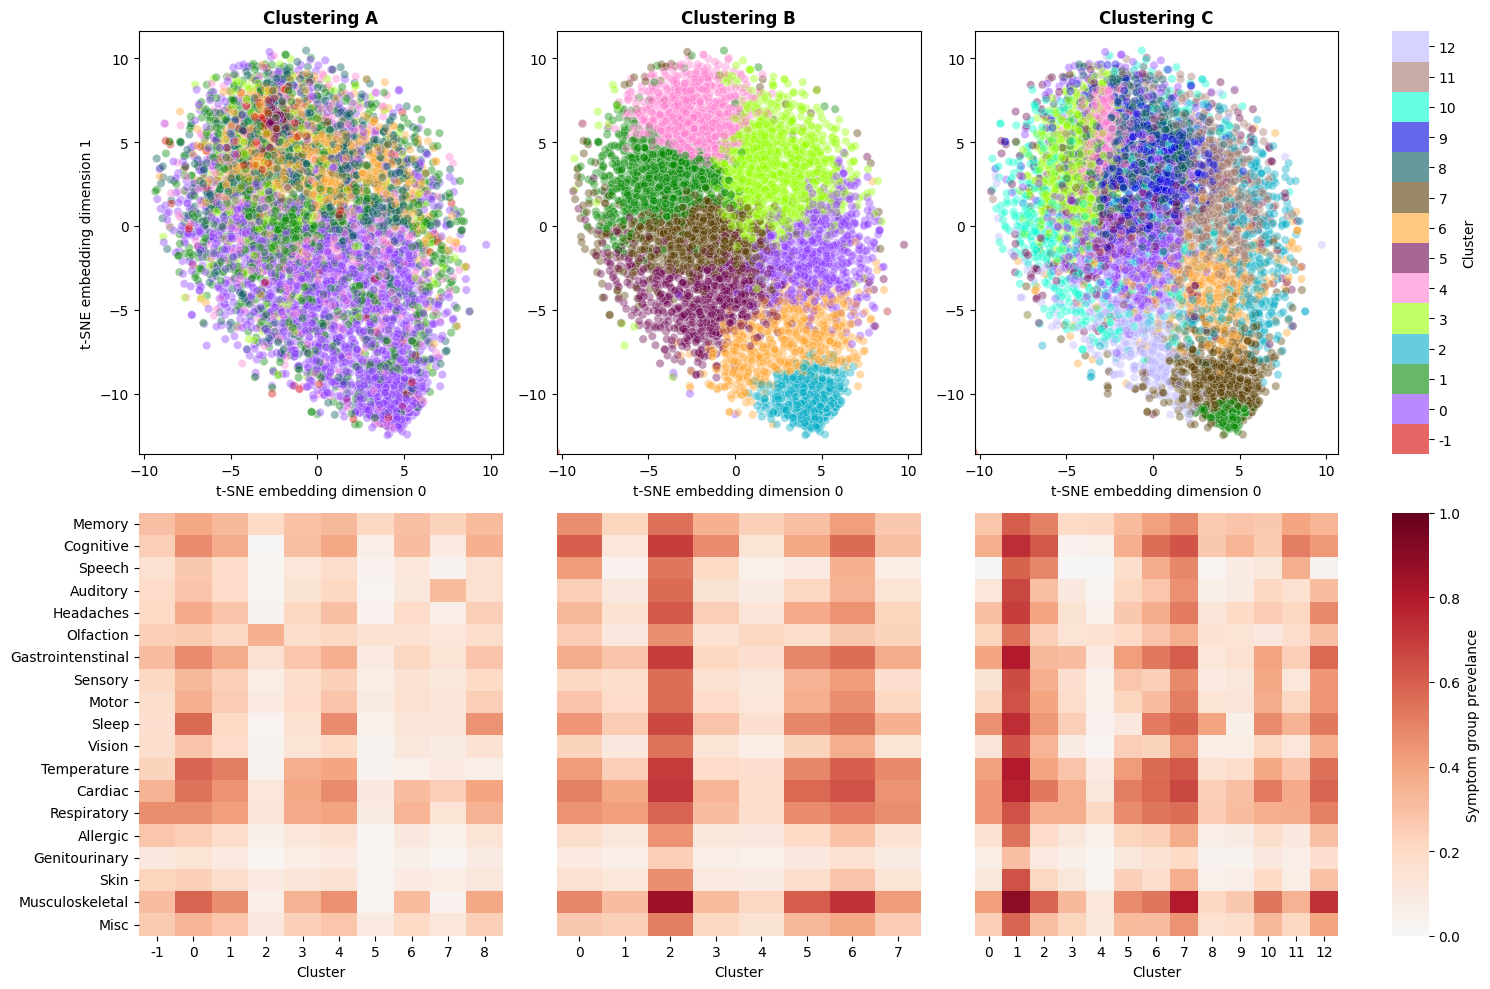

In [69]:
max_cluster_count = 14  # including -1 for noise
embedding_algo = 't-SNE'
alpha = 0.4 # for scatter plots

fig, ax = plt.subplots(2, 4, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

norm = plt.Normalize(0, max_cluster_count, )
palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count)
cmap = ListedColormap(palette.as_hex())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cluster_lists = [
    [c for c in leo_clusters.cluster],
    [c for c in chris_clusters.cluster] + [-1],
    [c for c in tessa_clusters.cluster] + [-1]
]
labels = ['A', 'B', 'C']
embedding_id = results_both_df.index[0]
em = results_both[embedding_id ]['embedding']

xmin = em[:,0].min()
xmax = em[:,0].max()
ymin = em[:,1].min()
ymax = em[:,1].max()

for i in range(3):
    
    # fix color mapping by to introducing -1 to clusterings B and C (not displayed)
    if i == 0:
        embedding = em
    else:
        embedding = np.append(em, [[xmin-1, ymin-1]], axis=0)
    
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        palette = palette,
        hue=cluster_lists[i],
        data=em,
        legend=None,
        ax=ax[0,i],
        alpha=alpha
        
    )
    ax[0,i].set_xlabel('%s embedding dimension 0' % embedding_algo)


ax[0,0].set_ylabel('%s embedding dimension 1' % embedding_algo)
cbar = fig.colorbar(sm, cax=ax[0,3], orientation="vertical", alpha=alpha*1.5, label='Cluster')
offset = ax[0,3].get_ylim()[1] / (2 * max_cluster_count)
cbar.set_ticks(np.arange(0, max_cluster_count) + offset, labels=[str(l) for l in range(-1,13)])
ax[0,3].set_frame_on(False)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(ax[0,0].get_ylim())
ax[0,2].set_xlim(ax[0,0].get_xlim())
ax[0,2].set_ylim(ax[0,0].get_ylim())

ax[0,0].set_title('Clustering A', fontweight='bold')
ax[0,1].set_title('Clustering B', fontweight='bold')
ax[0,2].set_title('Clustering C', fontweight='bold')


data1 = leodf.T
data2 = chrisdf.T
data3 = tessadf.T

cmap = "RdBu_r"

# Plot the first heatmap using Seaborn
sns.heatmap(data1, cmap=cmap, ax=ax[1,0], center = 0, cbar=False, vmin=0, vmax=1)
ax[1,0].set_xlabel('Cluster')
# ax[1,0].set_ylabel('Y-axis')

# Plot the second heatmap using Seaborn
sns.heatmap(data2, cmap=cmap, ax=ax[1,1],center = 0 , cbar=False, vmin=0, vmax=1)
ax[1,1].set_xlabel('Cluster')
ax[1,1].set_yticks([])  # Remove y-axis ticks for shared y-axis

# Plot the third heatmap using Seaborn
sns.heatmap(
    data3, cmap=cmap, ax=ax[1,2], center=0, cbar_ax=ax[1,3], vmin=0, vmax=1, 
    cbar_kws={'label': 'Symptom group prevelance'}
)
ax[1,2].set_xlabel('Cluster')
ax[1,2].set_yticks([])  # Remove y-axis ticks for shared y-axis

plt.tight_layout()

/tmp/ipykernel_25295/4111646222.py:35: UserWarning: The palette list has more values (14) than needed (10), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_25295/4111646222.py:35: UserWarning: The palette list has more values (14) than needed (9), which may not be intended.
  sns.scatterplot(


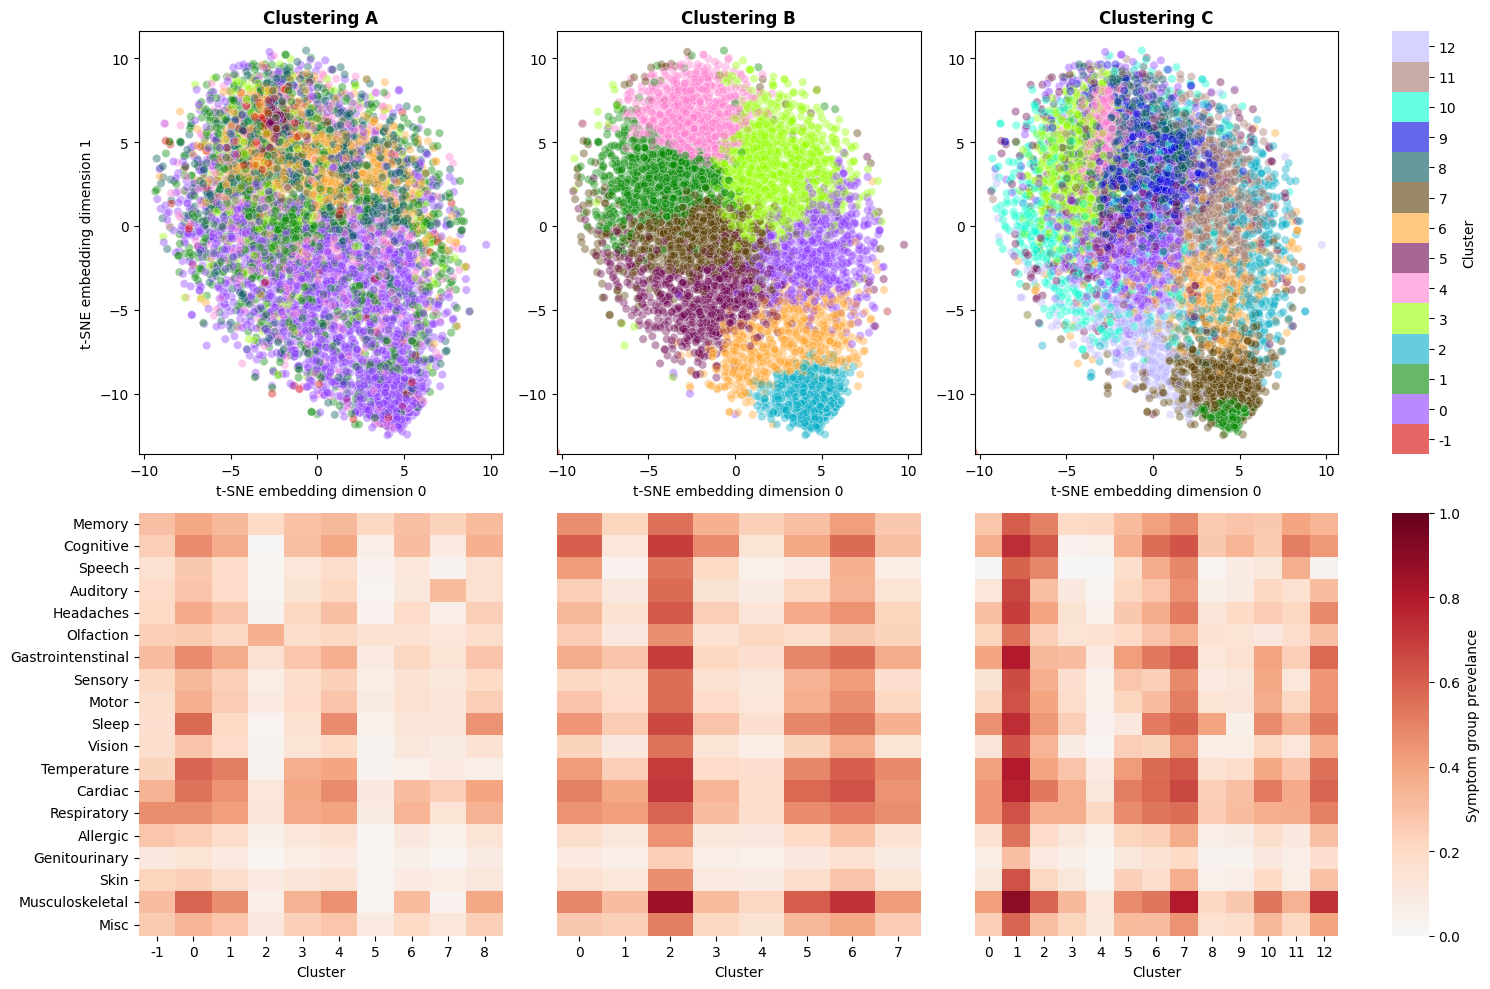

In [70]:
max_cluster_count = 14  # including -1 for noise
embedding_algo = 't-SNE'
alpha = 0.4 # for scatter plots

fig, ax = plt.subplots(2, 4, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

norm = plt.Normalize(0, max_cluster_count, )
palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count)
cmap = ListedColormap(palette.as_hex())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cluster_lists = [
    [c for c in leo_clusters.cluster],
    [c for c in chris_clusters.cluster] + [-1],
    [c for c in tessa_clusters.cluster] + [-1]
]
labels = ['A', 'B', 'C']
embedding_id = results_both_df.index[0]
em = results_both[embedding_id ]['embedding']

xmin = em[:,0].min()
xmax = em[:,0].max()
ymin = em[:,1].min()
ymax = em[:,1].max()

for i in range(3):
    
    # fix color mapping by to introducing -1 to clusterings B and C (not displayed)
    if i == 0:
        embedding = em
    else:
        embedding = np.append(em, [[xmin-1, ymin-1]], axis=0)
    
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        palette = palette,
        hue=cluster_lists[i],
        data=em,
        legend=None,
        ax=ax[0,i],
        alpha=alpha
        
    )
    ax[0,i].set_xlabel('%s embedding dimension 0' % embedding_algo)


ax[0,0].set_ylabel('%s embedding dimension 1' % embedding_algo)
cbar = fig.colorbar(sm, cax=ax[0,3], orientation="vertical", alpha=alpha*1.5, label='Cluster')
offset = ax[0,3].get_ylim()[1] / (2 * max_cluster_count)
cbar.set_ticks(np.arange(0, max_cluster_count) + offset, labels=[str(l) for l in range(-1,13)])
ax[0,3].set_frame_on(False)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(ax[0,0].get_ylim())
ax[0,2].set_xlim(ax[0,0].get_xlim())
ax[0,2].set_ylim(ax[0,0].get_ylim())

ax[0,0].set_title('Clustering A', fontweight='bold')
ax[0,1].set_title('Clustering B', fontweight='bold')
ax[0,2].set_title('Clustering C', fontweight='bold')


data1 = leodf.T
data2 = chrisdf.T
data3 = tessadf.T

cmap = "RdBu_r"

# Plot the first heatmap using Seaborn
sns.heatmap(data1, cmap=cmap, ax=ax[1,0], center = 0, cbar=False, vmin=0, vmax=1)
ax[1,0].set_xlabel('Cluster')
# ax[1,0].set_ylabel('Y-axis')

# Plot the second heatmap using Seaborn
sns.heatmap(data2, cmap=cmap, ax=ax[1,1],center = 0 , cbar=False, vmin=0, vmax=1)
ax[1,1].set_xlabel('Cluster')
ax[1,1].set_yticks([])  # Remove y-axis ticks for shared y-axis

# Plot the third heatmap using Seaborn
sns.heatmap(
    data3, cmap=cmap, ax=ax[1,2], center=0, cbar_ax=ax[1,3], vmin=0, vmax=1, 
    cbar_kws={'label': 'Symptom group prevelance'}
)
ax[1,2].set_xlabel('Cluster')
ax[1,2].set_yticks([])  # Remove y-axis ticks for shared y-axis

plt.tight_layout()
plt.savefig('figs/panel_plot.png')

In [56]:
# for ei in results_both_df.index:
#     max_cluster_count = 14
#     embedding_algo = 't-SNE'

#     fig, ax = plt.subplots(1, 3, figsize=(24, 6))

#     norm = plt.Normalize(0, max_cluster_count, )
#     palette = sns.color_palette(cc.glasbey, n_colors=max_cluster_count+1)
#     cmap = ListedColormap(palette.as_hex())
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])

#     cluster_lists = [
#         chris_clusters.cluster,
#         leo_clusters.cluster,
#         tessa_clusters.cluster,
#     ]
#     labels = ['A', 'B', 'C']
#     embedding_id = ei
#     em = results_both[embedding_id ]['embedding']

#     for i in range(3):

#         sns.scatterplot(
#             x=em[:, 0],
#             y=em[:, 1],
#             palette = palette,
#             hue=cluster_lists[i],
#             data=em,
#             legend=None,
#             ax=ax[i]
#         )
#         ax[i].set_xlabel('%s embedding dimension 0' % embedding_algo)
#         ax[i].text(
#             x=-11,
#             y=7.5,
#             s=labels[i],
#             fontsize='x-large',
#             fontweight='bold'
#         )    
#     #     plt.title(id)
#     #     ax[i].set_aspect('equal')

#     ax[0].set_ylabel('%s embedding dimension 1' % embedding_algo)
#     fig.colorbar(sm, ax=ax.flatten(), orientation="vertical");
#     plt.savefig('figs/embedding_%d.png' % ei)
#     # plt.tight_layout()


#### Testing the parametric UMAP embedding:

In [6]:
from umap.parametric_umap import ParametricUMAP

In [9]:
SEARCH_TYPE = 'randomized_search'  # we want random parameterisations for diversity.
SAMPLE_SIZE = 200  # number of sample to take from each pipeline to build library 
RUN_IDS_TO_INCLUDE = [1, 2, 5, 6]  # we will reproduce using only kmeans (and including p-umap)
NMI_SCORE = 'mi'  # arg to pass to clustering_similarity method to use partial NMI (ignoring -1 labels from hdbscan) 
SEED = 42
IGNORE_LABEL = None

In [7]:
run_metadata = {
    'randomized_search': {
        13: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/lo5r07or',
            'results_path': 'results/parametric_umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        15: {
            'run_path': 'rusty-chris/tune_shallow_clustering/tv9hnbnn',
            'results_path': 'results/parametric_umap_hdbscan_silhouette_run_10/all_results.pickle'
        }
    }
}

In [10]:
for key in run_metadata[SEARCH_TYPE].keys():
    run_configs[key].update(run_metadata[SEARCH_TYPE][key])

In [11]:
def load_results(run_id):
    run_config = run_configs[run_id]
    with open(run_config['results_path'], 'rb') as outfile:
        results = pk.load(outfile)
        
    results = pd.DataFrame.from_dict(results, orient='index')
    results['original_index'] = results.index
    results['run_id'] = run_id
    return results

In [12]:
all_results = {
    run_id: load_results(run_id)
    for run_id in run_metadata[SEARCH_TYPE].keys()
}

In [14]:
all_results[13].loc[6]

best_score                                                                                         0.431936
best_params                                               {'kmeans__init': 'random', 'kmeans__n_clusters...
current_params                                            {'kmeans__init': 'random', 'kmeans__n_clusters...
silhouette                                                                                         0.394842
dbcv                                                                                                     -1
rv                                                                                                       -1
calinski_harabasz                                                                               6893.140542
davies_bouldin                                                                                     0.776751
dbcv_minkowski                                                                                    -0.644813
fraction_clustered          